In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zszazi","key":"993dd55dbc522c9510115cad025c6073"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#change permission
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:14<00:00, 121MB/s]
100% 1.15G/1.15G [00:14<00:00, 85.6MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [6]:
!unzip chest_xray.zip

Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUM

In [0]:
PATH = "../content/chest_xray/train/"


In [0]:
!cd ../content/chest_xray/train/

In [13]:

!ls

chest_xray		  chest_xray.zip  __MACOSX
chest-xray-pneumonia.zip  kaggle.json	  sample_data


In [15]:
from os import path
path.exists(PATH)

True

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import accuracy
from fastai.callbacks import csv_logger

In [0]:
data = ImageDataBunch.from_folder(PATH, valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, bs = 32).normalize(imagenet_stats)

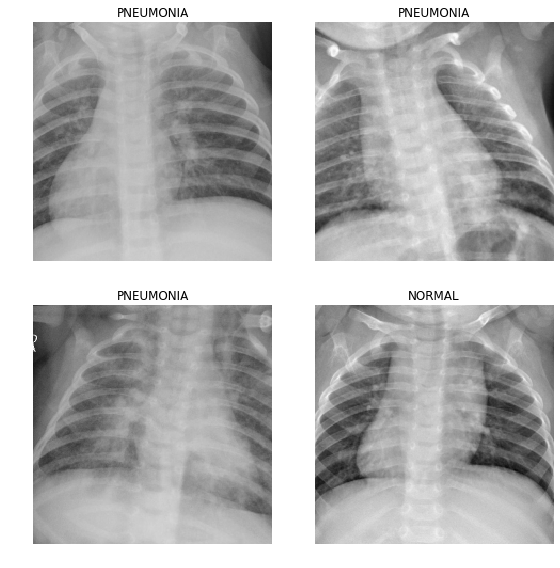

In [20]:
data.show_batch(rows = 2, fig = (5,5))

In [0]:
class NotificationCallback(Callback):
    """
        PyTorch callback for model training
    """
    
    def on_train_begin(self,epoch ,**kwargs):
        self.epoch = 0
        

    def on_epoch_end(self,epoch , metrics , **kwargs):
        val_loss, accuracy = metrics[0], metrics[1]
        message = "epoch: " + str(self.epoch) + " val loss: " + str(val_loss[0])[0:7] + " val acc: " + str(accuracy)[0:7]
        send = send_notification(message)
        self.epoch += 1

In [0]:
def send_notification(msg):
    """
        Send message to mobile using Pushover notifications.
        Calls Pushover API to do that.
        Pushover API docs: https://pushover.net/api
    """
    import requests
    from datetime import datetime

    url = "https://api.pushover.net/1/messages.json"
    data = {
        "user"  : "ubyy2b56hxjse9ne81iigm7w4hm363",
        "token" : "aaq548hx8mqespf6aiivmkomkhfqji",
        "sound" : "cashregister"
    }
    data["message"] = msg
    data['message'] = data['message'] + "\n" + str(datetime.now())

    r =  requests.post(url = url, data = data)

In [0]:
notif_cb = NotificationCallback()

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy,error_rate] , model_dir="/tmp/model/",callbacks = None)

In [73]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.269903,0.179490,0.937680,0.062320,03:12
1,0.167961,0.102193,0.963567,0.036433,03:14
2,0.127829,0.111288,0.956855,0.043145,03:14
3,0.107429,0.090598,0.964525,0.035475,03:13
4,0.093867,0.085111,0.963567,0.036433,03:14


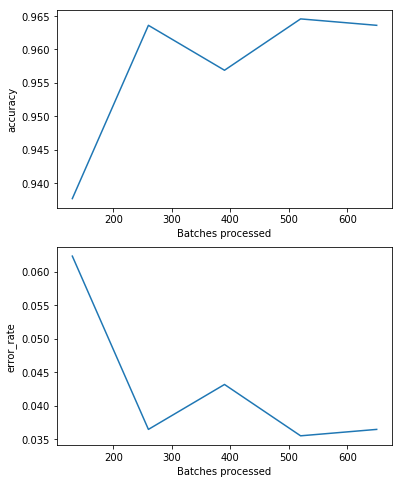

In [74]:
learn.recorder.plot_metrics()

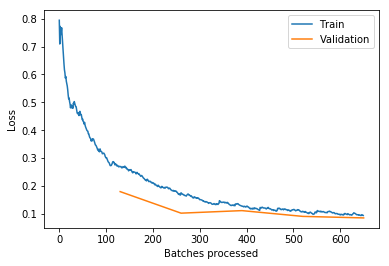

In [75]:
learn.recorder.plot_losses()

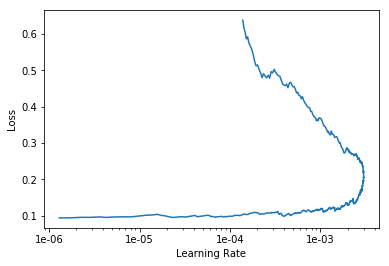

In [77]:
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.75E-05


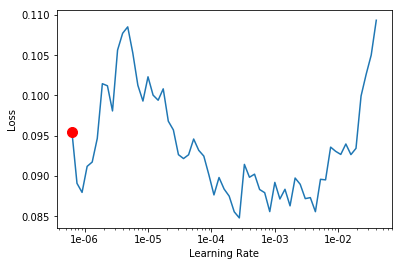

In [78]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

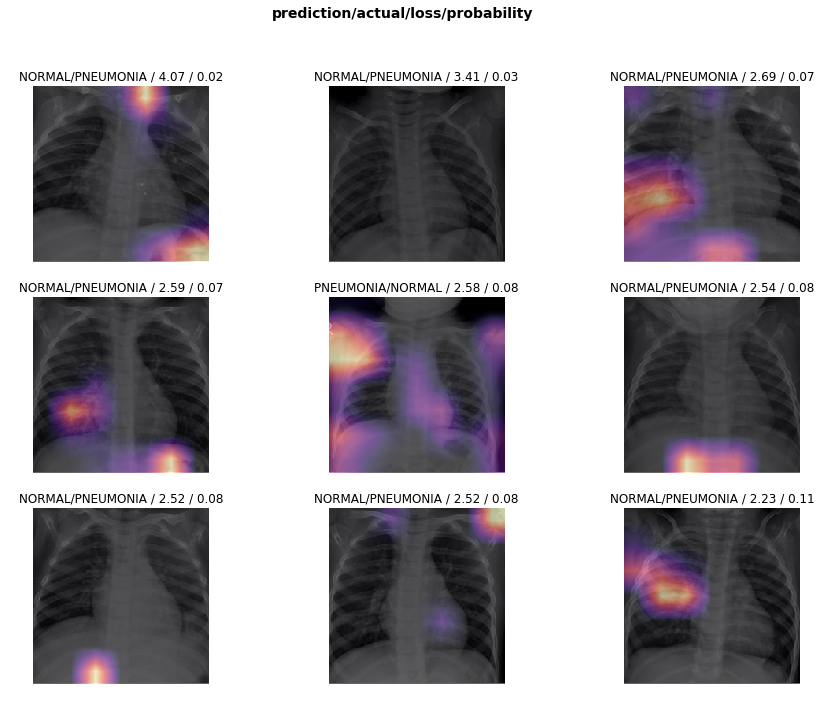

In [81]:
interp.plot_top_losses(9, figsize=(15,11))

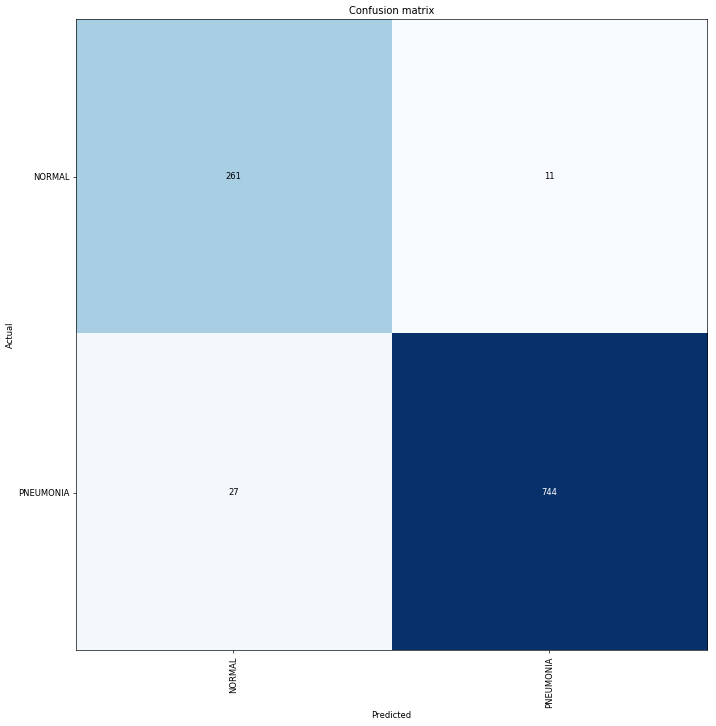

In [82]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
learn.unfreeze()

In [84]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.133321,0.076279,0.971237,0.028763,03:16


In [0]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 1.10E-07


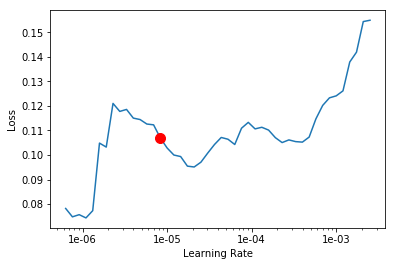

In [86]:

learn.lr_find()
learn.recorder.plot(suggestion = True)